In [50]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Solving the 1D Heat Equation

Let's solve the 1D heat equation! This partial differential equation describes the way heat diffuses throughout a region and is generally given by:
$$
u_t(x, t) = k u_{xx}(x, t)
$$

We will specifically be solving:
$$
u_t(x, t) = u_{xx}(x, t), \quad t\in[0,0.2], ~x\in [0,1]
$$

with Dirichlet boundary conditions

$$
u(0, t) = u(1, t) = 0
$$

and the following initial condition

$$
u(x, 0) = \text{sin}(\pi x)
$$

Let's have a look at the initial condition.

In [51]:
k = 1

def ic_eqn(x):
    return torch.sin(torch.pi * x)

# Exact solution for the heat equation ut = u_xx with the IC above
def exact_heat(x, t):
    u = np.exp(-k * np.pi ** 2 * t) * np.sin(np.pi * x)
    return u

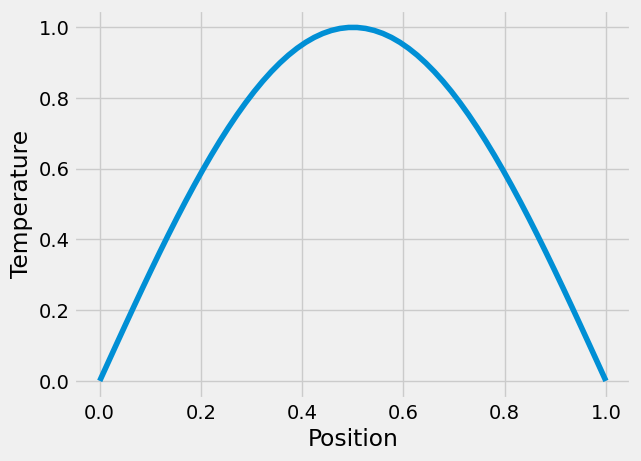

In [52]:
plt.style.use('fivethirtyeight')
x = torch.linspace(0, 1, 60)

plt.plot(x, ic_eqn(x))
plt.xlabel('Position')
plt.ylabel('Temperature')
plt.show()

We can imagine we have a rod that is warm at the center and we want to see how the heat will dissipate. Let's go ahead and train a model $u_{PINN}(x, t)$ to approximate the solution $u(x, t)$.

## Task 1: Determine solution to heat equation

We'll start by defining the neural network that we'll be using to approximate the solution. Notice that tanh is used instead of the popular ReLU! Why might this be?

In [53]:
class FCNN(nn.Module):
    def __init__(self, input_size=2, output_size=1, num_layers=4, layer_depth=32) -> None:
        super().__init__()
        layers = [nn.Linear(input_size, layer_depth),
                  nn.Tanh()]
        
        for i in range(num_layers - 2):
            layers.append(nn.Linear(layer_depth, layer_depth))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(layer_depth, output_size))

        self.layers = nn.Sequential(*layers)
        self.init_xavier()
        
    def forward(self, x):
        return self.layers(x)

    def init_xavier(self):
        torch.manual_seed(42)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

Next, let's choose some collocation points and set our boundary and intial condition points. In this case, we want to select points over time AND space. Ultimately, we want the following points:
* Randomly chosen points over time and space for assessing the PDE
* Points at the boundaries (at x=0 and x=1 for all time) to assess the boundary conditions
* Points at the intial state (all x at time=0) to assess the intial condition

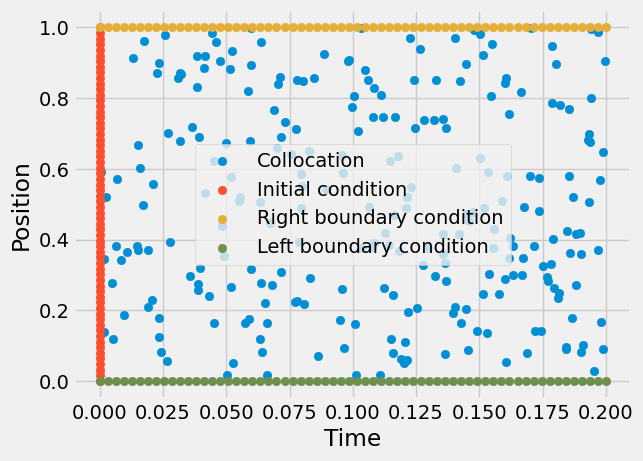

In [54]:
num_collocation = 256
num_ic = 64
num_bc = 64

torch.manual_seed(128)

# The last dimension will hold the position and time for each collocation sample
# Since we are going from time 0 to 1 and position 0 to 1, we are good to go
xt_collocation = torch.rand(num_collocation, 2)
xt_collocation[..., 1] = xt_collocation[..., 1] * 0.2

# For the IC, we want t=0 and a variety of x points
xt_ic = torch.empty((num_ic, 2))
xt_ic[..., 0] = torch.linspace(0, 1, num_ic)
xt_ic[..., 1] = 0

# Right boundary condition: set x=1, and a variety of times
xt_bc_right = torch.empty((num_bc, 2))
xt_bc_right[..., 0] = 1
xt_bc_right[..., 1] = torch.linspace(0, 0.2, num_bc)

# Left boundary condition: set x=0, and a variety of times
xt_bc_left = torch.empty((num_bc, 2))
xt_bc_left[..., 0] = 0
xt_bc_left[..., 1] = torch.linspace(0, 0.2, num_bc)

plt.scatter(xt_collocation[..., 1], xt_collocation[..., 0], label='Collocation')
plt.scatter(xt_ic[..., 1], xt_ic[..., 0], label='Initial condition')
plt.scatter(xt_bc_right[..., 1], xt_bc_right[..., 0], label='Right boundary condition')
plt.scatter(xt_bc_left[..., 1], xt_bc_left[..., 0], label='Left boundary condition')

plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.show()



Now we can start training! In our loss function, we will have a few terms to minimize:
* The PDE, or physics term: $u_t(x_{\text{col}}, t_{\text{col}}) - u_{xx}(x_{\text{col}}, t_{\text{col}})$
* The initial condition term: $u(x_{\text{IC}}, 0) - \text{sin}(\pi x)$
* The right boundary condition term: $u(1, t_{\text{BC}})$
* The left boundary condition term: $u(0, t_{\text{BC}})$

You'll notice we won't do any normalizing or scaling of the data. Why might that be?

Epoch 0:, Loss: 56.52262
Epoch 1000:, Loss: 0.37508
Epoch 2000:, Loss: 0.02780
Epoch 3000:, Loss: 0.00649
Epoch 4000:, Loss: 0.00280
Epoch 5000:, Loss: 0.00132
Epoch 6000:, Loss: 0.00067
Epoch 7000:, Loss: 0.00042
Epoch 8000:, Loss: 0.00038
Epoch 9000:, Loss: 0.00022
Epoch 10000:, Loss: 0.01835
Epoch 11000:, Loss: 0.00014
Epoch 12000:, Loss: 0.00015
Epoch 13000:, Loss: 0.00016
Epoch 14000:, Loss: 0.00008


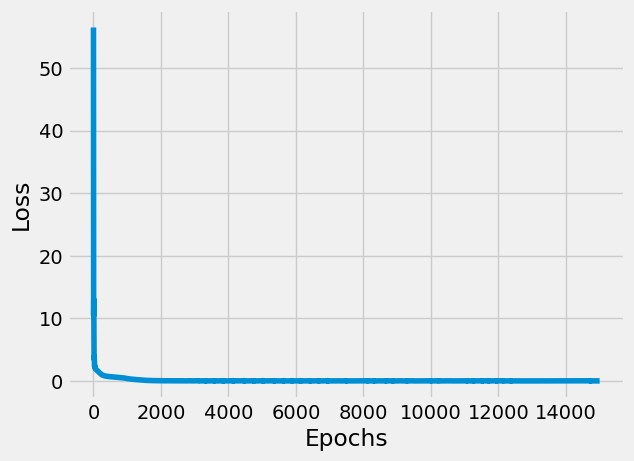

In [55]:
# Fix up torch inputs to require gradients
xt_collocation = xt_collocation.to(device).requires_grad_()
xt_ic = xt_ic.to(device).requires_grad_()
xt_bc_right = xt_bc_right.to(device).requires_grad_()
xt_bc_left = xt_bc_left.to(device).requires_grad_()

# set model and optimizer
model = FCNN(num_layers=5, layer_depth=20)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# weights for balancing our loss terms
weights = [1, 10, 5, 5]
losses = []

for i in range(15000):
    optimizer.zero_grad()

    ## PDE loss ##
    u_pde = model(xt_collocation)

    grad_u = torch.autograd.grad(u_pde.sum(), xt_collocation, create_graph=True)[0]
    grad_u_t = grad_u[:, 1]
    grad_u_x = grad_u[:, 0]
    grad_u_xx = torch.autograd.grad(grad_u_x.sum(), xt_collocation, create_graph=True)[0][:, 0]

    pde_term = torch.mean((grad_u_t - k * grad_u_xx) ** 2)

    ## IC loss ##
    u_ic = model(xt_ic)
    ic_exact = ic_eqn(xt_ic[..., 0])

    ic_term = torch.mean((u_ic.squeeze() - ic_exact) ** 2)

    ## BC right loss ##
    u_bc_right = model(xt_bc_right)
    bc_right_term = torch.mean((u_bc_right) ** 2)

    ## BC left loss ##
    u_bc_left = model(xt_bc_left)
    bc_left_term = torch.mean((u_bc_left) ** 2)

    # Total loss
    loss = weights[0] * pde_term + weights[1] * ic_term \
        + weights[2] * bc_right_term + weights[3] * bc_left_term
    
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if i % 1000 == 0:
        print(f'Epoch {i}:, Loss: {loss.item():.5f}')

plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


### Testing 

Now we can test our model! 

We'll look at the following to assess our perfomance:
* Relative absolute error to get a general sense of our performance
* Predicted heat
* Exact heat
* The absolute error map

In [56]:
x, t = torch.linspace(0, 1, 100), torch.linspace(0, 0.2, 100)
x_grid, t_grid = torch.meshgrid(x, t)
exact = exact_heat(x_grid, t_grid)

xt = torch.stack([x_grid.flatten(), t_grid.flatten()], dim=-1).to(device)
model.eval()

with torch.no_grad():
    u = model(xt)
    u = u.cpu().detach()
    u = u.reshape(x_grid.shape)

error_map = abs((u - exact))
relative_absolute_error= (torch.mean(abs(u - exact)) / torch.mean(torch.abs(exact))) * 100
print(f"Relative absolute error: {relative_absolute_error.item():.3f}%",)

Relative absolute error: 0.160%


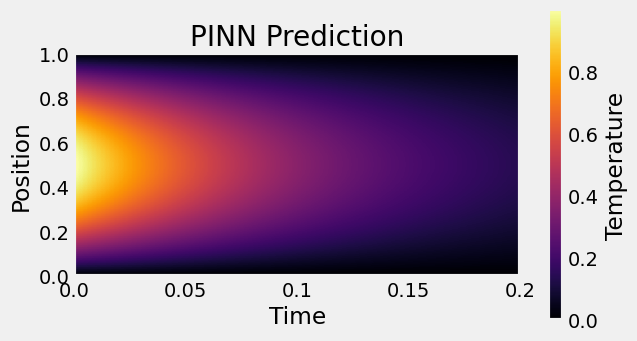

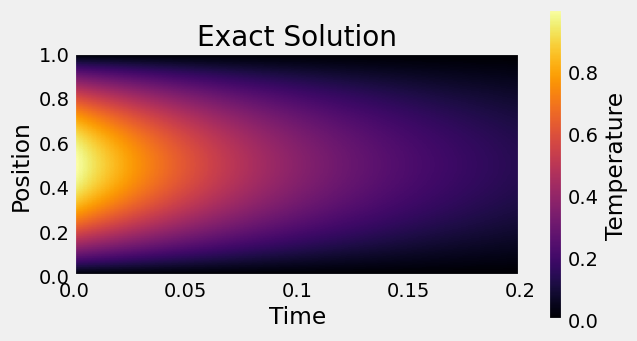

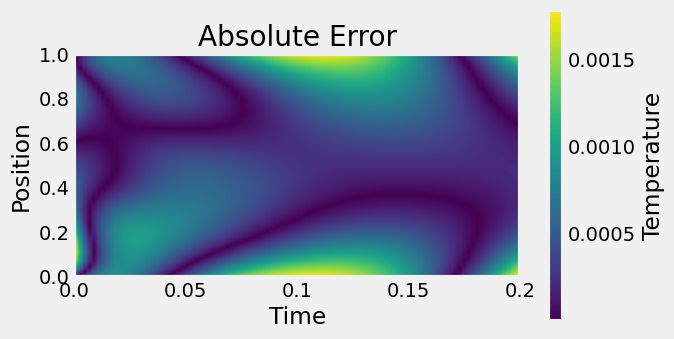

In [57]:
def plot_map(map_data, title='', cmap='inferno', vmin=None, vmax=None):
    plt.style.use('fivethirtyeight')
    plt.imshow(map_data, cmap=cmap, extent=(0, 2, 0, 1), vmin=vmin, vmax=vmax)
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.title(title)
    ax = plt.gca()
    ax.set_xticks([0.0, 0.5, 1, 1.5, 2])
    ax.set_xticklabels([0.0, 0.05, 0.1, 0.15, 0.2])
    ax.grid(False)
    cbar = plt.colorbar(shrink=0.8)
    cbar.set_label('Temperature')
    plt.show()

    return

vmin = min(u.min(), exact.min())
vmax = max(u.max(), exact.max())
plot_map(u, title='PINN Prediction', vmin=vmin, vmax=vmax)
plot_map(exact, title='Exact Solution', vmin=vmin, vmax=vmax)
plot_map(error_map, cmap='viridis', title='Absolute Error')

## Task 2: Learn parameters of the heat equation


In the previous task, we trained our model to approximate the solution to the heat equation. To do this, we used the exact value of $k$ in our PDE loss term, as well as the exact values of the boundary and initial conditions. Now, let's approach it from the other way around: given some noisy data, can we determine the paramters of the PDE? i.e.) Can we learn $k$?

Let's start by generating some noisy data.

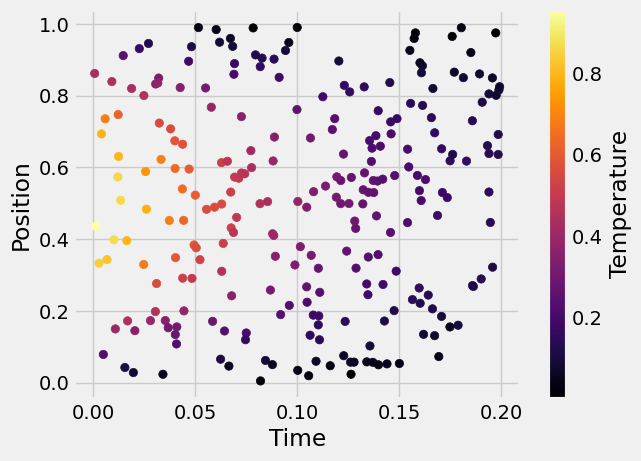

In [58]:
num_data = 256

xt_data = torch.rand(num_data, 2)
xt_data[..., 1] = xt_data[..., 1] * 0.2
u_data_true = exact_heat(xt_data[..., 0], xt_data[..., 1]) + torch.randn(num_data) * 0.01
plt.scatter(xt_data[..., 1], xt_data[..., 0], c=u_data_true, cmap='inferno')
plt.xlabel('Time')
plt.ylabel('Position')
cbar = plt.colorbar()
cbar.set_label('Temperature')
plt.show()

Next, we're going to train our model. Our loss terms look a bit different this time around. We want to minimize

* The PDE, or physics term: $u_t(x_{\text{col}}, t_{\text{col}}) - ku_{xx}(x_{\text{col}}, t_{\text{col}})$.
* The supervised, or data loss: $u(x_{\text{data}}, t_{\text{data}}) - u_{\text{exact}}(x_{\text{data}}, t_{\text{data}})$

The first term is the same as before, except this time, k is a trainable parameter! The second term will minimize the difference between our model output and the observed data. Note that for this task, the model needs to learn the solution to the heat equation AND the parameter $k$ that governs the heat equation.

Epoch 0:, Loss: 0.72755
Epoch 1000:, Loss: 0.03777
Epoch 2000:, Loss: 0.00643
Epoch 3000:, Loss: 0.00206
Epoch 4000:, Loss: 0.00141
Epoch 5000:, Loss: 0.00121
Epoch 6000:, Loss: 0.00112
Epoch 7000:, Loss: 0.00106
Epoch 8000:, Loss: 0.00103
Epoch 9000:, Loss: 0.00101


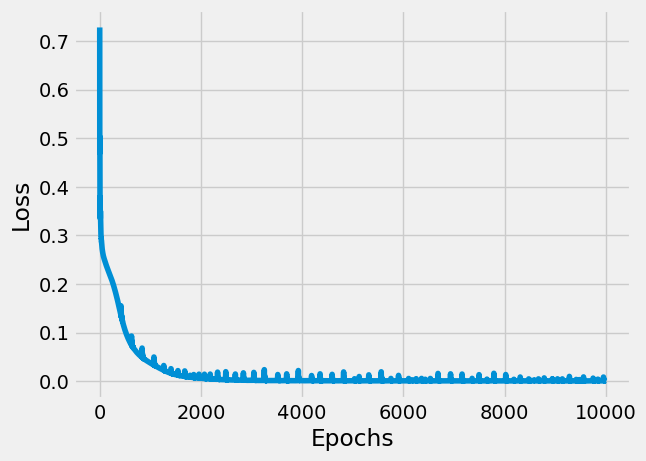

In [59]:
# Fix up torch inputs to require gradients
xt_collocation = xt_collocation.to(device).requires_grad_()
xt_data = xt_data.to(device)
u_data_true = u_data_true.to(device)

# set model and optimizer
model = FCNN(num_layers=5, layer_depth=20)
model.to(device)
# K is set as a trainable parameter and added to the optimizer alongside the model
k_model = torch.nn.Parameter(torch.zeros(1, requires_grad=True, device=device))
optimizer = torch.optim.Adam(list(model.parameters()) + [k_model], lr=0.001)

weights = [1, 10]
losses = []
ks = []

for i in range(10000):
    optimizer.zero_grad()

    ## PDE loss ##
    u_pde = model(xt_collocation)

    grad_u = torch.autograd.grad(u_pde.sum(), xt_collocation, create_graph=True)[0]
    grad_u_t = grad_u[:, 1]
    grad_u_x = grad_u[:, 0]
    grad_u_xx = torch.autograd.grad(grad_u_x.sum(), xt_collocation, create_graph=True)[0][:, 0]

    pde_term = torch.mean((grad_u_t - k_model * grad_u_xx) ** 2)

    ## Data loss ##
    u_data_pred = model(xt_data)
    data_term = torch.mean((u_data_pred.squeeze() - u_data_true) ** 2)

    # Total loss
    loss = weights[0] * pde_term + weights[1] * data_term
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    ks.append(k_model.item())

    if i % 1000 == 0:
        print(f'Epoch {i}:, Loss: {loss.item():.5f}')

plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


Let's see whether we converged to the correct value of k.

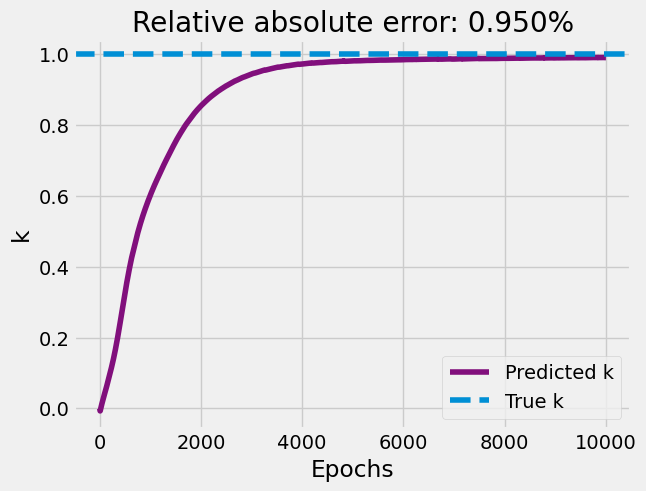

In [60]:
plt.plot(ks, color='C5', label='Predicted k')
plt.axhline(1, linestyle='--', c='C0', label=r'True k')
plt.xlabel('Epochs')
plt.ylabel('k')
plt.legend()
relative_absolute_error= (abs(ks[-1] - k) / k) * 100

plt.title(f"Relative absolute error: {relative_absolute_error:.3f}%")
plt.show()

We can also have a look at the solution our model learnt. Even though this wasn't necessarily our goal to find the PDE solution, we get it as a bonus when we solve the inverse problem.

In [61]:
x, t = torch.linspace(0, 1, 100), torch.linspace(0, 0.2, 100)
x_grid, t_grid = torch.meshgrid(x, t)
exact = exact_heat(x_grid, t_grid)

xt = torch.stack([x_grid.flatten(), t_grid.flatten()], dim=-1).to(device)
model.eval()

with torch.no_grad():
    u = model(xt)
    u = u.cpu().detach()
    u = u.reshape(x_grid.shape)

error_map = abs((u - exact))
relative_absolute_error= (torch.mean(abs(u - exact)) / torch.mean(torch.abs(exact))) * 100
print(f"Relative absolute error: {relative_absolute_error.item():.3f}%",)

Relative absolute error: 0.742%


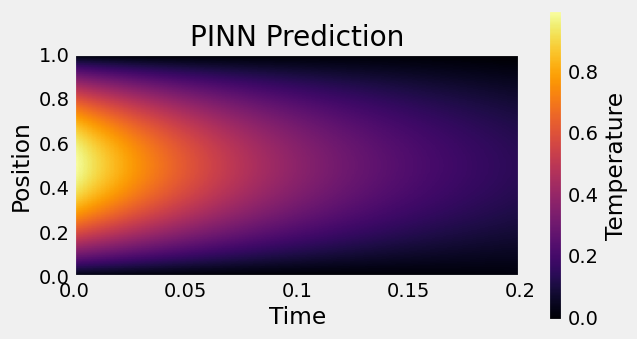

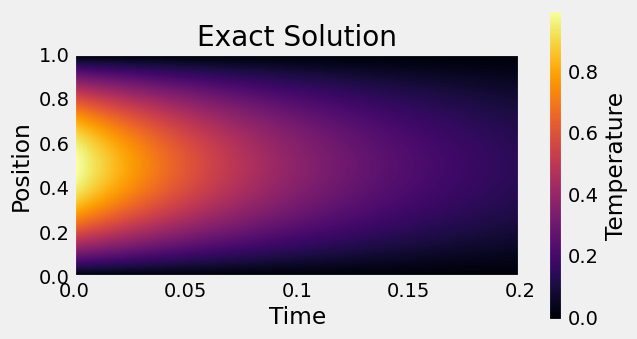

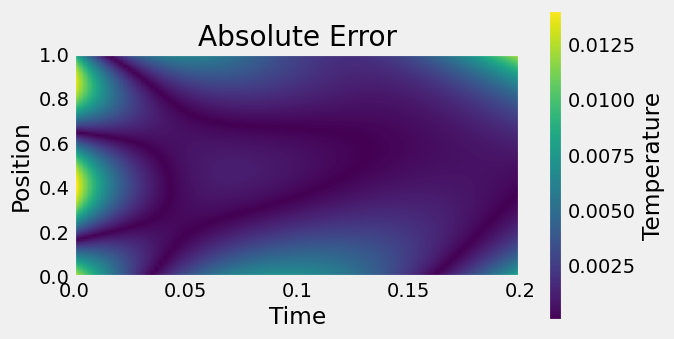

In [62]:
vmin = min(u.min(), exact.min())
vmax = max(u.max(), exact.max())
plot_map(u, title='PINN Prediction', vmin=vmin, vmax=vmax)
plot_map(exact, title='Exact Solution', vmin=vmin, vmax=vmax)
plot_map(error_map, cmap='viridis', title='Absolute Error')